In [1]:
import os
import tempfile
import shutil
import sys
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import numpy as np

from monai.data import CSVDataset, CSVIterableDataset, DataLoader
from monai.apps import download_and_extract
from monai.config import print_config
from monai.transforms import Compose, LoadImaged, ToNumpyd

In [4]:
ADNI1_label = '../Datasets/ADNI/ADNI1_modality_complete_new.csv'
ADNI2_label = '../Datasets/ADNI/ADNI2_modality_complete_new.csv'
ADNI_label = '../Datasets/ADNI/ADNI.csv'


In [9]:
pd.read_csv(ADNI_label)['Subject'].tolist()

['126_S_0865',
 '007_S_4516',
 '137_S_4631',
 '022_S_0014',
 '035_S_4414',
 '035_S_4256',
 '036_S_5210',
 '116_S_4483',
 '057_S_1373',
 '023_S_2068',
 '016_S_4583',
 '012_S_0637',
 '082_S_4428',
 '128_S_0245',
 '098_S_4201',
 '019_S_4549',
 '128_S_1409',
 '011_S_0362',
 '013_S_4595',
 '068_S_2187',
 '127_S_4604',
 '022_S_0544',
 '018_S_0043',
 '141_S_4426',
 '013_S_1161',
 '137_S_4351',
 '009_S_5027',
 '011_S_4278',
 '007_S_0128',
 '137_S_0158',
 '051_S_5005',
 '072_S_4394',
 '100_S_4469',
 '022_S_4444',
 '073_S_2264',
 '003_S_4373',
 '037_S_4410',
 '094_S_2367',
 '072_S_4941',
 '041_S_4877',
 '070_S_4692',
 '099_S_4463',
 '013_S_4791',
 '032_S_4429',
 '036_S_5112',
 '011_S_0861',
 '072_S_4769',
 '041_S_1412',
 '067_S_2195',
 '121_S_1322',
 '035_S_0204',
 '007_S_0101',
 '041_S_4874',
 '002_S_4262',
 '128_S_1407',
 '128_S_0258',
 '012_S_1165',
 '067_S_2304',
 '007_S_4568',
 '036_S_1001',
 '057_S_0818',
 '019_S_4548',
 '137_S_4756',
 '067_S_4310',
 '127_S_4928',
 '016_S_4952',
 '073_S_42

In [21]:
from collections import OrderedDict

import torch
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

manual_seed(666)

roc_auc = ROC_AUC()
#The ``output_transform`` arg of the metric can be used to perform a sigmoid on the ``y_pred``.
roc_auc.attach(default_evaluator, 'roc_auc')
y_pred = torch.tensor([[0.0474], [0.5987], [0.7109], [0.9997]])
y_true = torch.tensor([[0], [0], [1], [0]])
default_evaluator.run([[y_pred, y_true]])
print(default_evaluator.state.metrics['roc_auc'])

0.6666666666666667


In [37]:
from monai.networks.nets.resnet import resnet10
import torch

resnet = resnet10(n_input_channels=1, feed_forward=False)
# for k in resnet.state_dict().keys():
#     print(k)
# input_example = torch.ones([1,1,25,25,25])
# output_example = resnet(input_example)
# output_example.shape

In [38]:
resnet

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine

In [28]:
import torch
from models.resnet import resnet10
resnet = resnet10()

In [29]:
med3d = torch.load('./models/resnet_10_23dataset.pth')['state_dict']
med3d_state_dict = {}
for k,v in med3d.items():
    med3d_state_dict[k.split('module.')[-1]] = v
resnet.load_state_dict(med3d_state_dict)

<All keys matched successfully>

In [34]:
input_sample = torch.ones((1, 1, 144, 184, 152))
output = resnet(input_sample)

In [36]:
resnet

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

In [14]:
import torch
from torch import nn

class SFCN(nn.Module):
    def __init__(self):
        super(SFCN, self).__init__()
        self.maxpool = nn.MaxPool3d(2, stride=2)
        self.block1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )

    def forward(self, x):
        x_pooled = self.maxpool(x)
        block1_out = self.block1(x_pooled)
        block2_out = self.block2(block1_out)
        block3_out = self.block3(block2_out)
        block4_out = self.block4(block3_out)
        block5_out = self.block5(block4_out)
        return block5_out

a = torch.zeros((4, 1, 148, 182, 162))
model = SFCN()
b = model(a)

In [15]:
b.shape

torch.Size([4, 128, 4, 5, 5])

In [23]:
import glob
import os
import pandas as pd

root_path = '../Datasets/U8Data'
csv = pd.read_csv('../Datasets/U8Data/label.csv')
all_subjects = csv['ID']
subjects_with_FDG = []
for sub in all_subjects:
    FDG_path = glob.glob(os.path.join(root_path, sub, 'FDG', 'U8PET*.nii.gz'))
    if not FDG_path:
        print(sub)
    print(FDG_path[-1])

../Datasets/U8Data\AFM0002\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0003\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0004\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0006\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0007\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0008\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0009\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0010\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0012\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0013\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0014\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0015\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0016\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0017\FDG\U8PET_Brain_iterative3D_(AC).nii.gz
../Datasets/U8Data\AFM0018\FDG\U8PET_Brain_iterative3D_(AC).ni

In [25]:
root_path = '../Datasets/U8Data'
csv = pd.read_csv('../Datasets/U8Data/label.csv')
all_subjects = csv['ID']
subjects_with_FDG = []
for sub in all_subjects:
    MRI_path = os.path.join(root_path, sub, 'MRI', 'U8T1brain.nii.gz')
    if not os.path.exists(MRI_path):
        print(sub)

In [21]:
import torch
from einops.layers.torch import Rearrange
from torch import nn

class sNet(nn.Module):
    def __init__(self, dim) -> None:
        super().__init__()
        self.maxpool = nn.MaxPool3d(2, stride=2)
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, dim//8, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(dim//8),
            nn.GELU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(dim//8, dim//4, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(dim//4),
            nn.GELU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(dim//4, dim//2, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(dim//2),
            nn.GELU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(dim//2, dim, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(dim),
            nn.GELU(),
            nn.MaxPool3d(2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv3d(dim, dim, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(dim),
            nn.GELU(),
        )
        self.fc = nn.Sequential(
            nn.AvgPool3d(2, stride=2),
            Rearrange('b c x y z -> b (c x y z)'),
            nn.Linear(dim * 2 * 2 * 3, 2)
        )

    def forward(self, mri):
        mri_pooled = self.maxpool(mri)
        conv1_out = self.conv1(mri_pooled)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv4_out)
        # logits = self.fc(F.normalize(conv5_out, p=2, dim=-1))
        # logits = self.fc(conv5_out)
        return conv5_out

a = torch.zeros((4, 1, 148, 182, 162))
model = sNet(128)
conv5_out = model(a)
conv5_out.shape

torch.Size([4, 128, 4, 5, 5])

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

a = np.arange(10)
train, test = train_test_split(a, test_size=0.2, random_state=42, shuffle=True)

In [9]:
from torch.utils.data import SubsetRandomSampler

aaa = SubsetRandomSampler(train)

In [8]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
import torch as t
import torch.nn.functional as F


class FALoss(t.nn.modules.loss._Loss):
    __constants__ = ['reduction']

    @staticmethod
    def _calculate_matrix_similarity(feature_map):
        feature_map_normalized = t.div(feature_map, t.linalg.norm(feature_map, ord=2, dim=(2, 3), keepdims=True))
        print(t.linalg.norm(feature_map, ord=2, dim=(2, 3), keepdims=True).shape)
        return t.matmul(t.transpose(feature_map_normalized, dim0=2, dim1=3), feature_map_normalized)


    def __init__(self, subsample_factor:int=8, size_average=None, reduce=None, reduction='mean') -> None:
        super().__init__(size_average=None, reduce=None, reduction=reduction)
        self.subsample_factor = subsample_factor

    def forward(self, feature_map1: t.Tensor, feature_map2: t.Tensor) -> t.Tensor:

        # Subsample feature map and then calculate matrix similarity
        S_feature_map1 = FALoss._calculate_matrix_similarity(feature_map1)
        S_feature_map2 = FALoss._calculate_matrix_similarity(feature_map2)

        # Create repeats of matrix similarity so that we can calculate L1 norm between each element of one matrix to every other element
        S_feature_map1 = t.flatten(S_feature_map1, start_dim=2, end_dim=3)
        S_feature_map1 = t.repeat_interleave(S_feature_map1, repeats=S_feature_map1.shape[-1], dim=2)
        S_feature_map2 = t.flatten(S_feature_map2, start_dim=2, end_dim=3)
        S_feature_map2 = S_feature_map2.repeat(1, 1, S_feature_map2.shape[-1])

        return F.l1_loss(S_feature_map1,
                         S_feature_map2,
                         reduction=self.reduction)

a = t.randn(4, 128, 5, 5)
b = t.randn(4, 128, 5, 5)
loss = FALoss()
faloss = loss(a,b)

torch.Size([4, 128, 1, 1])
torch.Size([4, 128, 1, 1])


In [9]:
from models.mymodel import model_ad

model = model_ad(dim=128, depth=6, heads=4, dim_head=32, mlp_dim=512, dropout=0.1)

for (name, module) in model.named_modules():
    print(name)


mri_cnn
mri_cnn.maxpool
mri_cnn.conv1
mri_cnn.conv1.0
mri_cnn.conv1.1
mri_cnn.conv1.2
mri_cnn.conv1.3
mri_cnn.conv2
mri_cnn.conv2.0
mri_cnn.conv2.1
mri_cnn.conv2.2
mri_cnn.conv2.3
mri_cnn.conv3
mri_cnn.conv3.0
mri_cnn.conv3.1
mri_cnn.conv3.2
mri_cnn.conv3.3
mri_cnn.conv4
mri_cnn.conv4.0
mri_cnn.conv4.1
mri_cnn.conv4.2
mri_cnn.conv4.3
mri_cnn.conv5
mri_cnn.conv5.0
mri_cnn.conv5.1
mri_cnn.conv5.2
pet_cnn
pet_cnn.maxpool
pet_cnn.conv1
pet_cnn.conv1.0
pet_cnn.conv1.1
pet_cnn.conv1.2
pet_cnn.conv1.3
pet_cnn.conv2
pet_cnn.conv2.0
pet_cnn.conv2.1
pet_cnn.conv2.2
pet_cnn.conv2.3
pet_cnn.conv3
pet_cnn.conv3.0
pet_cnn.conv3.1
pet_cnn.conv3.2
pet_cnn.conv3.3
pet_cnn.conv4
pet_cnn.conv4.0
pet_cnn.conv4.1
pet_cnn.conv4.2
pet_cnn.conv4.3
pet_cnn.conv5
pet_cnn.conv5.0
pet_cnn.conv5.1
pet_cnn.conv5.2
fuse_transformer
fuse_transformer.layers
fuse_transformer.layers.0
fuse_transformer.layers.0.0
fuse_transformer.layers.0.0.layers
fuse_transformer.layers.0.0.layers.0
fuse_transformer.layers.0.0.layers.0

In [22]:
import pandas as pd
csv = pd.read_csv('./t1_paths.tsv', sep='\t')
csv = csv[(csv.Visit == 'ADNI Screening') | (csv.Visit == 'ADNI2 Screening MRI-New Pt')]
csv = csv[(csv.VISCODE == 'bl')]
sub_list = list(csv['Image_ID'])
for item in sub_list:
    print(item, end=',')
sub_list_unique = set(sub_list)
len(sub_list_unique)

35475,32237,64631,32246,33025,59366,32270,59375,33066,32306,32332,32409,391070,389161,38717,45166,33074,35875,34607,35734,31084,387867,36485,59398,35888,33086,64390,35819,35486,35825,86354,35893,388020,36501,108504,35902,35833,31102,388029,59446,96211,35790,33105,36628,64395,388925,34316,35911,68120,51999,88356,31125,31143,31205,66413,36504,64400,49675,388924,35841,64405,31251,64410,59456,64046,35920,36726,39460,36509,65478,40445,64417,63454,35933,35849,35799,63551,34325,34114,34332,63784,35671,31271,36640,59484,59524,104521,31300,33396,36886,37210,65130,36892,39533,33489,65739,384819,92666,64422,39810,35499,40858,65752,96321,34797,34806,33799,34136,65134,32003,40179,40201,384777,37217,69639,33109,40239,40452,40260,68802,39542,68813,63114,60600,37224,68835,31346,59533,72128,54686,32855,68842,68711,49735,92342,68745,33493,39108,51151,32020,34819,68861,36530,34150,34824,68879,34362,34384,124897,68898,65257,68927,33428,33433,39486,66428,34837,39117,37007,39112,34846,34524,395090,39569,365

2246

In [17]:
import pandas as pd
csv = pd.read_csv('./ADNI.csv')
sub_list = csv['Subject']
for item in list(sub_list):
    print(item, end=',')
len(sub_list)

941_S_4764,941_S_4420,941_S_4377,941_S_4376,941_S_4365,941_S_4292,941_S_4255,941_S_4187,941_S_4100,941_S_4066,941_S_4036,941_S_1311,941_S_1295,941_S_1203,941_S_1202,941_S_1197,941_S_1195,941_S_1194,153_S_4838,153_S_4621,153_S_4372,153_S_4297,153_S_4172,153_S_4159,153_S_4151,153_S_4139,153_S_4133,153_S_4125,153_S_4077,141_S_4976,141_S_4907,141_S_4819,141_S_4803,141_S_4711,141_S_4456,141_S_4438,141_S_4426,141_S_4423,141_S_4232,141_S_4160,141_S_4053,141_S_1378,141_S_1245,137_S_4852,137_S_4816,137_S_4815,137_S_4756,137_S_4678,137_S_4672,137_S_4632,137_S_4631,137_S_4623,137_S_4596,137_S_4587,137_S_4536,137_S_4520,137_S_4482,137_S_4466,137_S_4351,137_S_4331,137_S_4303,137_S_4299,137_S_4258,137_S_4211,137_S_1426,137_S_1414,137_S_1041,137_S_0994,137_S_0973,137_S_0972,137_S_0841,137_S_0825,137_S_0800,137_S_0722,137_S_0686,137_S_0669,137_S_0481,137_S_0459,137_S_0443,137_S_0438,137_S_0301,137_S_0283,137_S_0158,136_S_4517,136_S_4433,136_S_4408,136_S_4269,136_S_4189,136_S_0695,135_S_5275,135_S_5015

1071

In [6]:
import os
import glob

# 使用FreeSurfer对图像进行颅骨剥离
print("FreeSurfer start......\n")
# 图像坐在的目录
#------------------------图像路径需更改------------------------#
path ="/media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS"
# 读取目录下的.img文件列表，*.img表示该目录下所有以.img结尾的文件
#-----------------------图像后缀名需更改--- -------------------#
files = glob.glob(os.path.join(path,"*", 'ses-M00', '*', "*.nii.gz"))
# 输出路径
#------------------------输出路径需更改------------------------#
out_path="/media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS_SkullTripped"
print("number: ",len(files))
# 下面为freesurfer的环境配置命令
a = "export FREESURFER_HOME=/home/kateridge/freesurfer;"
b = "source $FREESURFER_HOME/SetUpFreeSurfer.sh;"
# 数据所在的目录
c = "export SUBJECTS_DIR="+path+";"

for file in files:
    out_filename = file.split('BIDS/')[-1]
    # 当前输出文件路径，以.nii.gz格式保存
    cur_out_path=os.path.join(out_path,out_filename)
    print("file name: ",file)
    cmd = a + b + c + "mri_watershed "+file+" "+ cur_out_path
    os.system(cmd)

print("\n\nEnd")

FreeSurfer start......

number:  2134
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI041S0721/ses-M00/anat/sub-ADNI041S0721_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI041S0721/ses-M00/pet/sub-ADNI041S0721_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4171/ses-M00/anat/sub-ADNI002S4171_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4171/ses-M00/pet/sub-ADNI002S4171_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4213/ses-M00/anat/sub-ADNI002S4213_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4213/ses-M00/pet/sub-ADNI002S4213_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4219/ses-M00/anat/sub-ADNI002S4219_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI002S4219/ses-M

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S0950/ses-M00/anat/sub-ADNI109S0950_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S0950/ses-M00/pet/sub-ADNI109S0950_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S0967/ses-M00/anat/sub-ADNI109S0967_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S0967/ses-M00/pet/sub-ADNI109S0967_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S1013/ses-M00/anat/sub-ADNI109S1013_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S1013/ses-M00/pet/sub-ADNI109S1013_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S1114/ses-M00/anat/sub-ADNI109S1114_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI109S1114/ses-M00/pet/sub-ADNI109S1114_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4391/ses-M00/anat/sub-ADNI072S4391_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4391/ses-M00/pet/sub-ADNI072S4391_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4394/ses-M00/anat/sub-ADNI072S4394_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4394/ses-M00/pet/sub-ADNI072S4394_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4445/ses-M00/anat/sub-ADNI072S4445_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4445/ses-M00/pet/sub-ADNI072S4445_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4462/ses-M00/anat/sub-ADNI072S4462_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI072S4462/ses-M00/pet/sub-ADNI072S4462_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0389/ses-M00/anat/sub-ADNI053S0389_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0389/ses-M00/pet/sub-ADNI053S0389_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0621/ses-M00/anat/sub-ADNI053S0621_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0621/ses-M00/pet/sub-ADNI053S0621_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0919/ses-M00/anat/sub-ADNI053S0919_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S0919/ses-M00/pet/sub-ADNI053S0919_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S1044/ses-M00/anat/sub-ADNI053S1044_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI053S1044/ses-M00/pet/sub-ADNI053S1044_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S0973/ses-M00/anat/sub-ADNI137S0973_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S0973/ses-M00/pet/sub-ADNI137S0973_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S0994/ses-M00/anat/sub-ADNI137S0994_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S0994/ses-M00/pet/sub-ADNI137S0994_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S1041/ses-M00/anat/sub-ADNI137S1041_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S1041/ses-M00/pet/sub-ADNI137S1041_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S1414/ses-M00/anat/sub-ADNI137S1414_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI137S1414/ses-M00/pet/sub-ADNI137S1414_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4741/ses-M00/pet/sub-ADNI009S4741_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4814/ses-M00/anat/sub-ADNI009S4814_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4814/ses-M00/pet/sub-ADNI009S4814_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4903/ses-M00/anat/sub-ADNI009S4903_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4903/ses-M00/pet/sub-ADNI009S4903_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4958/ses-M00/anat/sub-ADNI009S4958_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S4958/ses-M00/pet/sub-ADNI009S4958_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI009S5000/ses-M00/anat/sub-ADNI009S5000_ses

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S0289/ses-M00/anat/sub-ADNI130S0289_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S0289/ses-M00/pet/sub-ADNI130S0289_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S0783/ses-M00/anat/sub-ADNI130S0783_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S0783/ses-M00/pet/sub-ADNI130S0783_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S1200/ses-M00/anat/sub-ADNI130S1200_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S1200/ses-M00/pet/sub-ADNI130S1200_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S1201/ses-M00/anat/sub-ADNI130S1201_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI130S1201/ses-M00/pet/sub-ADNI130S1201_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI027S0461/ses-M00/pet/sub-ADNI027S0461_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4232/ses-M00/anat/sub-ADNI141S4232_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4232/ses-M00/pet/sub-ADNI141S4232_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4423/ses-M00/anat/sub-ADNI141S4423_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4423/ses-M00/pet/sub-ADNI141S4423_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4426/ses-M00/anat/sub-ADNI141S4426_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4426/ses-M00/pet/sub-ADNI141S4426_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI141S4438/ses-M00/anat/sub-ADNI141S4438_ses

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4217/ses-M00/anat/sub-ADNI068S4217_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4217/ses-M00/pet/sub-ADNI068S4217_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4274/ses-M00/anat/sub-ADNI068S4274_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4274/ses-M00/pet/sub-ADNI068S4274_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4332/ses-M00/anat/sub-ADNI068S4332_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4332/ses-M00/pet/sub-ADNI068S4332_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4340/ses-M00/anat/sub-ADNI068S4340_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI068S4340/ses-M00/pet/sub-ADNI068S4340_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S1037/ses-M00/anat/sub-ADNI032S1037_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S1037/ses-M00/pet/sub-ADNI032S1037_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4277/ses-M00/anat/sub-ADNI032S4277_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4277/ses-M00/pet/sub-ADNI032S4277_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4348/ses-M00/anat/sub-ADNI032S4348_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4348/ses-M00/pet/sub-ADNI032S4348_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4386/ses-M00/anat/sub-ADNI032S4386_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI032S4386/ses-M00/pet/sub-ADNI032S4386_ses-M00_trc-18

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1:

 /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4546/ses-M00/anat/sub-ADNI006S4546_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4546/ses-M00/pet/sub-ADNI006S4546_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4679/ses-M00/anat/sub-ADNI006S4679_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4679/ses-M00/pet/sub-ADNI006S4679_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4713/ses-M00/anat/sub-ADNI006S4713_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4713/ses-M00/pet/sub-ADNI006S4713_ses-M00_trc-18FFDG_pet.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4867/ses-M00/anat/sub-ADNI006S4867_ses-M00_T1w.nii.gz
file name:  /media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS/sub-ADNI006S4867/ses-M00/pet/sub-ADNI006S4867_ses-M00_trc-18FFDG_pet.ni

sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found
sh: 1: source: not found
sh: 1: mri_watershed: not found


In [4]:
import os
import glob
#------------------------图像路径需更改------------------------#
path ="/media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS"
# 读取目录下的.img文件列表，*.img表示该目录下所有以.img结尾的文件
#-----------------------图像后缀名需更改--- -------------------#
files = glob.glob(os.path.join(path,"*", 'ses-M00', '*', "*.nii.gz"))
# 输出路径
#------------------------输出路径需更改------------------------#
out_path="/media/kateridge/新加卷/Datasets/ADNI_FDG/BIDS_SkullTripped"
print("number: ",len(files))
# 下面为freesurfer的环境配置命令
a = "export FREESURFER_HOME=/home/kateridge/freesurfer;"
b = "source $FREESURFER_HOME/SetUpFreeSurfer.sh;"
# 数据所在的目录
c = "export SUBJECTS_DIR="+path+";"

files[0].split('BIDS/')[-1]

number:  2134


'sub-ADNI041S0721/ses-M00/anat/sub-ADNI041S0721_ses-M00_T1w.nii.gz'

In [3]:
import torch
from torch import nn
from models.resnet import generate_model

model_CNN = generate_model(10, n_input_channels=1)
temp = torch.zeros((2, 1, 79, 95, 79))
_, _ = model_CNN(temp)

torch.Size([2, 512, 5, 3, 3])


In [9]:
import glob
import SimpleITK as sitk
import numpy as np
import os
import monai
from monai.transforms import LoadImage, SaveImage, SpatialResample, Compose, AddChannel

mri_files = glob.glob('../Datasets/ADNI/MRI/NIIGZ_Origin/*.nii')
sub_t1 = sitk.ReadImage(mri_files[0])
sub_t1_np = sitk.GetArrayFromImage(sub_t1)
sub_t1_np = sub_t1_np[np.newaxis, :]

resample_transform = SpatialResample()
sub_t1_np_resampled = resample_transform(sub_t1_np, spatial_size=(128,128,79))

sub_pet_img_out = sitk.GetImageFromArray(sub_t1_np_resampled[0].squeeze())
sub_pet_img_out.SetDirection(sub_t1.GetDirection())
sub_pet_img_out.SetOrigin(sub_t1.GetOrigin())
sub_pet_img_out.SetSpacing(sub_t1.GetSpacing())
sitk.WriteImage(sub_pet_img_out, os.path.join('../Datasets/ADNI_ADVIT/MRI/NIIGZ_Origin/', 'aaa.nii'))


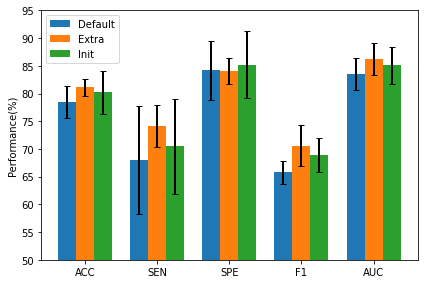

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['ACC', 'SEN', 'SPE', 'F1', 'AUC']
default = [78.5, 68.0, 84.2, 65.8, 83.5]
default_err = [2.9, 9.8, 5.3, 2.1, 2.9]
extra = [81.1, 74.2, 84.1, 70.6, 86.2]
extra_err = [1.6, 3.8, 2.4, 3.7, 2.9]
init = [80.2, 70.5, 85.2, 68.9, 85.1]
init_err = [3.9, 8.6, 6.0, 3.0, 3.3]


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, default, width, label='Default')
ax.errorbar(x - width, default, yerr=default_err, capsize=3, elinewidth=2, fmt='k,')
rects2 = ax.bar(x, extra, width, label='Extra')
ax.errorbar(x, extra, yerr=extra_err, capsize=3, elinewidth=2, fmt='k,')
rects3 = ax.bar(x + width, init, width, label='Init')
ax.errorbar(x + width, init, yerr=init_err, capsize=3, elinewidth=2, fmt='k,')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance(%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
#
#
# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
ax.set_ylim([50, 95])
# plt.show()
plt.savefig('a.png')

AFM0002
AFM0003
AFM0004
AFM0006
AFM0007
AFM0008
AFM0009
AFM0010
AFM0012
AFM0013
AFM0014
AFM0015
AFM0016
AFM0017
AFM0018
AFM0019
AFM0020
AFM0021
AFM0022
AFM0023
AFM0025
AFM0026
AFM0027
AFM0028
AFM0029
AFM0030
AFM0031
AFM0032
AFM0033
AFM0034
AFM0035
AFM0036
AFM0037
AFM0039
AFM0040
AFM0043
AFM0045
AFM0049
AFM0063
AFM0069
AFM0070
AFM0071
AFM0081
AFM0083
AFM0086
AFM0088
AFM0094
AFM0095
AFM0096
AFM0097
AFM0102
AFM0103
AFM0107
AFM0111
AFM0114
AFM0115
AFM0118
AFM0120
AFM0121
AFM0122
AFM0123
AFM0126
AFM0127
AFM0128
AFM0129
AFM0131
AFM0133
AFM0134
AFM0135
AFM0136
AFM0137
AFM0138
AFM0146
AFM0149
AFM0152
AFM0153
AFM0155
AFM0162
AFM0220_AM5
AFM0230
AFM0401
AFM0428
AFM0429
AFM0430
AFM0431
AFM0444
